In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Layer, Input


In [40]:
#filename = "ah78_long.csv"
filename = "ah78_month.csv"
#filename = "ah78_week.csv"

ts = pd.read_csv("simple_"+filename, index_col=0)
ts.index = pd.DatetimeIndex(ts.index.values, freq="5min")
ts.describe()


,y,a,b,c,h,yy,dy,B,A,C
count,7957.000000,8064.000000,8064.000000,8064.000000,3066.000000,8064.000000,8063.000000,8064.000000,8.064000e+03,8064.000000
mean,6.335716,5.135185,0.162712,0.606647,68.751931,6.340375,-0.000633,0.162680,5.135259e+00,0.606619
std,1.785341,16.261032,0.473934,4.299443,16.504785,1.786439,0.289426,0.060509,1.514972e+01,0.954469
min,2.164790,0.000000,0.000000,0.000000,41.000000,2.164790,-2.053780,0.043988,2.108928e-40,0.000000
25%,4.995670,0.000000,0.000000,0.000000,58.500000,4.995670,-0.166520,0.115482,6.825560e-10,0.005172
50%,6.050320,0.813500,0.063532,0.000000,66.000000,6.050320,0.000000,0.155945,1.250000e+00,0.173505
75%,7.493510,2.853500,0.119538,0.000000,73.500000,7.493510,0.111020,0.201714,3.695659e+00,0.793974
max,12.655700,192.893043,7.592103,60.000000,168.500000,12.655700,1.720730,0.520829,1.588831e+02,6.648057


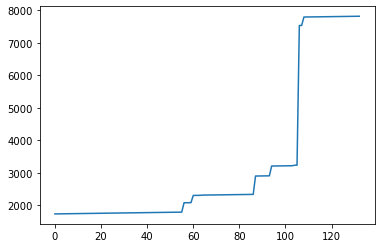

2905

In [41]:
fp_list = [i for i in range(len(ts.fp)) if ts.fp.iloc[i]]

plt.plot(fp_list)
plt.show()

j = np.random.choice(fp_list)
j


In [90]:
N = len(ts)
ts_test = ts.iloc[:N//5]
ts_train = ts.iloc[N//5:]
tau = 1

exogenous = ["a","b","c","A","B","C"]
no_exogen = len(exogenous)

lag = 0 # 6

N_train = len(ts_train)
X_train = np.vstack([ts_train["yy"].values[l:N_train-tau-lag+l] for l in range(1+lag)]).T
if no_exogen > 0:
    X_train = np.hstack([X_train,ts_train[exogenous].values[:N_train-tau-lag]])
Y_train = ts_train["yy"].values[lag+tau:]

#X_test = ts_test[features].iloc[:-tau] 
#Y_test = ts_test["yy"].iloc[tau:]

N_test = len(ts_test)
X_test = np.vstack([ts_test["yy"].values[l:N_test-tau-lag+l] for l in range(1+lag)]).T
if no_exogen > 0:
    X_test = np.hstack([X_test,ts_test[exogenous].values[:N_test-tau-lag]])
Y_test = ts_test["yy"].values[lag+tau:]

#plt.plot(X_train[:50,:1+lag])
#plt.plot(Y_train[:50], '--')
#plt.show()
#plt.plot(X_test[:50,:1+lag])
#plt.plot(Y_test[:50], '--')
#plt.show()

no_features = no_exogen + 1 + lag

N_train, X_train.shape, Y_train.shape, N_test, X_test.shape, Y_test.shape, no_features


(6452, (6451, 7), (6451,), 1612, (1611, 7), (1611,), 7)

In [91]:
def mdn_cost(mu, sigma, y):
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    return tf.reduce_mean(-dist.log_prob(y))


In [97]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
InputLayer = Input(shape=(no_features,))
#Layer_1 = Dense(12,activation="tanh")(InputLayer)
#Layer_2 = Dense(12,activation="tanh")(Layer_1)
Layer_1 = Dense(12,activation="relu")(InputLayer)
Layer_2 = Dense(12,activation="relu")(Layer_1)
mu = Dense(1, activation="linear")(Layer_2)
sigma = Dense(1, activation=lambda x: tf.nn.elu(x) + 1)(Layer_2)
y_real = Input(shape=(1,))
lossF = mdn_cost(mu,sigma,y_real)
model = Model(inputs=[InputLayer, y_real], outputs=[mu, sigma])
model.add_loss(lossF)
adamOptimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adamOptimizer,metrics=['mse'])
history_cache = model.fit([X_train, Y_train], #notice we are using an input to pass the real values due to the inner workings of keras
                          verbose=1, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)
print('Final cost: {0:.4f}'.format(history_cache.history['loss'][-1]))
mu_pred, sigma_pred = model.predict(list((X_test,Y_test))) # the model expects a list of arrays as it has 2 inputs


Epoch 1/500
130/130 [==============================] - 1s 2ms/step - loss: 4.3889 - dense_30_mse: 0.0000e+00 - dense_31_mse: 0.0000e+00
Epoch 2/500
130/130 [==============================] - 0s 2ms/step - loss: 3.3685 - dense_30_mse: 0.0000e+00 - dense_31_mse: 0.0000e+00
Epoch 3/500
130/130 [==============================] - 0s 2ms/step - loss: 3.0089 - dense_30_mse: 0.0000e+00 - dense_31_mse: 0.0000e+00
Epoch 4/500
130/130 [==============================] - 0s 2ms/step - loss: 2.7983 - dense_30_mse: 0.0000e+00 - dense_31_mse: 0.0000e+00
Epoch 5/500
130/130 [==============================] - 0s 2ms/step - loss: 2.6721 - dense_30_mse: 0.0000e+00 - dense_31_mse: 0.0000e+00
Epoch 6/500
130/130 [==============================] - 0s 2ms/step - loss: 2.5646 - dense_30_mse: 0.0000e+00 - dense_31_mse: 0.0000e+00
Epoch 7/500
130/130 [==============================] - 0s 2ms/step - loss: 2.4670 - dense_30_mse: 0.0000e+00 - dense_31_mse: 0.0000e+00
Epoch 8/500
130/130 [===========================

In [98]:
mu_pred.shape, sigma_pred.shape

((1611, 1), (1611, 1))

In [99]:
time_index = ts_test.index[lag+tau:]
predicted_mean = mu_pred[:,0]
predicted_sigma = sigma_pred[:,0]

time_index.shape

(1611,)

In [100]:
j = 500

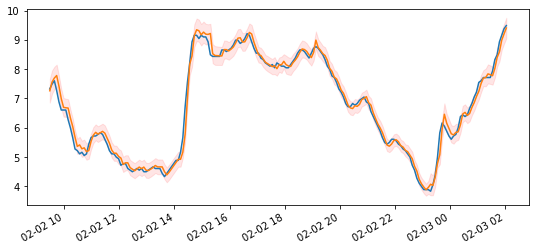

In [101]:
fig, ax = plt.subplots(figsize=(9,4))
ts_test.loc[time_index[j-100:j+100]]["yy"].plot()

plt.plot(time_index[j-100:j+100], predicted_mean[j-100:j+100])
upper = (predicted_mean + predicted_sigma)[j-100:j+100]
lower = (predicted_mean - predicted_sigma)[j-100:j+100]
ax.fill_between(time_index[j-100:j+100], upper, lower, color='r', alpha=0.1)

#plt.plot(ts.index[j-100:j+100], predict_dy.predicted_mean[j-100:j+100])
#ci = predict_dy_ci.values
#ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='g', alpha=0.1)

plt.show()

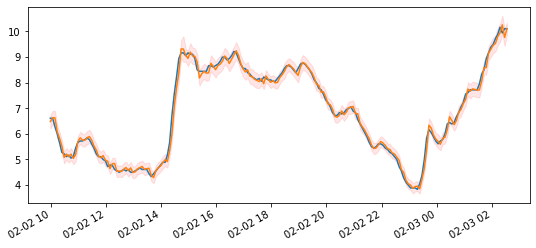

In [89]:
fig, ax = plt.subplots(figsize=(9,4))
ts_test.loc[time_index[j-100:j+100]]["yy"].plot()

plt.plot(time_index[j-100:j+100], predicted_mean[j-100:j+100])
upper = (predicted_mean + predicted_sigma)[j-100:j+100]
lower = (predicted_mean - predicted_sigma)[j-100:j+100]
ax.fill_between(time_index[j-100:j+100], upper, lower, color='r', alpha=0.1)

#plt.plot(ts.index[j-100:j+100], predict_dy.predicted_mean[j-100:j+100])
#ci = predict_dy_ci.values
#ax.fill_between(ts.index[j-100:j+100], ci[j-100:j+100,0], ci[j-100:j+100,1], color='g', alpha=0.1)

plt.show()